# Object Classification

[Jack Yao](https://github.com/j-ackyao)

### Sections
- **Introduction**
  - Libraries and data
  - Preliminary analysis
- **Model training and testing**
  - K-nearest neighbour algorithm
  - Convolutional neural networks
    - LeNet-5
    - VGG16
  - Review of the classification models
- **Discussion**
  - Ethics and the future


## Introduction

As technology becomes increasingly advanced, new technologic domains of study are continuously emerging, with artificial intelligence being one that is now established in the real world. Within the expansive realm of AI, many subject areas have gained prominence and developed into their own subfields, namely computer vision.

Computer vision can approached through various algorithms and architectures, but the goal remains the same: to identify and understand the contents of a digital image or video. Although various different technology can be used to in computer vision, the most common path is through convolutional neural networks (CNN), a neural network model that learns features from structured data (such as images) via kernel optimization. The models often consists of three main building blocks: convolution and pooling layers for feature extraction and regular dense layers for classification (Patel et al.).

The aim of this project is to accomplish object classification through computer vision using different methods to compare and contrast. In addition, this is a personal exploration into neural networks (i.e. CNNs).

### Libraries and data
This section will import the necessary libraries and load datasets used to train and test the models.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# keras
import keras.api._v2.keras as keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout
from keras.layers import Activation, MaxPool2D, Dropout, Flatten, Reshape
import keras.optimizers as optimizers
from keras.activations import softmax

The dataset used is called CIFAR-10, collected by Alex Krizhevsky and his team as a subset of the 80 million tiny images dataset. It contains 50000 colored training images of dimensions 32x32 in 10 classes with additional 10000 images available for testing, but for simplicity only the 50000 is used as the quantity is sufficient. The corresponding labels and description follows the table below:

|Label|Description|
|-|-|
|0|airplane|
|1|automobile|
|2|bird|
|3|cat|
|4|deer|
|5|dog|
|6|frog|
|7|horse|
|8|ship|
|9|truck|

In [2]:
# load cifar10 dataset
(x_cifar, y_cifar), _ = cifar10.load_data()
y_cifar = y_cifar.reshape(50000,)
# rename and possible combine other datasets here
images = x_cifar
labels = y_cifar

170498071/170498071 [==============================] - 14s 0us/step


### Preliminary analysis
This secion will take a closer look at the dataset and perform any preprocessing that would be needed for all models.

Shape of image data: (50000, 32, 32, 3)
Width of images: 32
Height of images: 32
Class of example: ship
AxesImage(size=(32, 32))


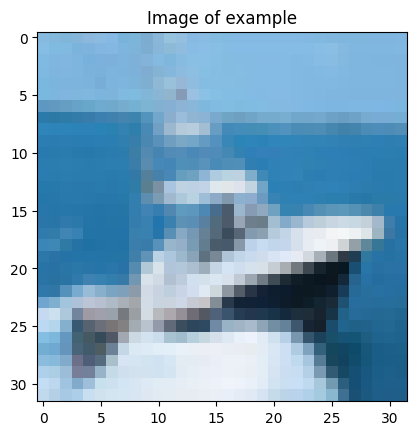

In [25]:
# label numeric to string
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
def label_to_string(x):
  return classes[x]

example_index = 8
example_image = images[example_index].copy()

# get dimensions of data
width = images.shape[1]
height = images.shape[2]

print("Shape of image data:", images.shape)
print("Width of images:", width)
print("Height of images:", height)
print("Class of example:", label_to_string(labels[example_index]))

# show example image
plt.title("Image of example")
print(plt.imshow(example_image))

From the `image_data.shape` above, it can be seen that the 50000 represents the number of images, 32 represents the dimensions of the image, and the 3 represents the RGB values in the respective order.

AxesImage(size=(32, 32))


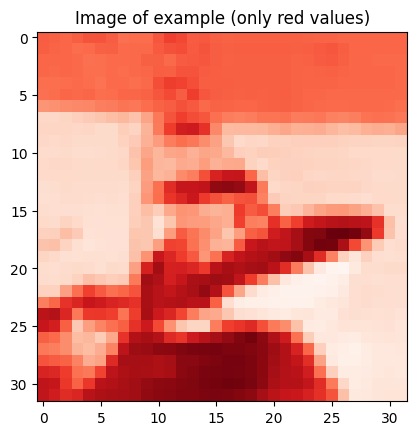

In [4]:
# show example image but only the red values (darker indicates higher red value)
plt.title("Image of example (only red values)")
print(plt.imshow(example_image[:,:,0], cmap = "Reds"))

As previously noted, the number of images in each class is 5000, with 10 classes totaling up to 50000 images. This can be seen in the graph below:

Axes(0.125,0.11;0.775x0.77)


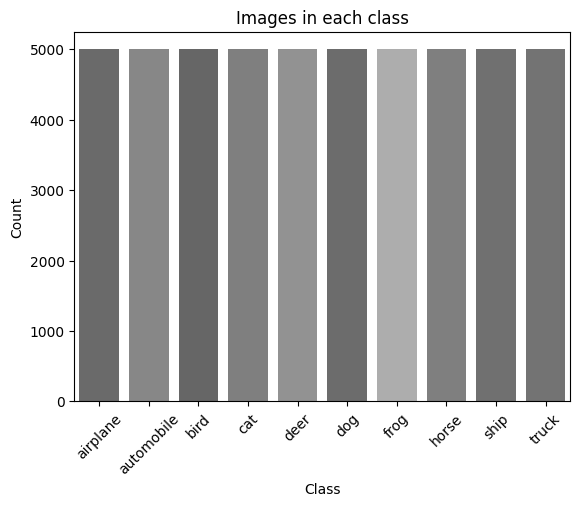

In [5]:
# plot number of data in each class
data_plot = np.unique(list(map(label_to_string, labels)), return_counts = True)
plt.xticks(rotation=45)
plt.title("Images in each class")
plt.ylabel("Count")
plt.xlabel("Class")
print(sns.barplot(x = data_plot[0], y = data_plot[1], saturation = 0))

Below is preprocessing that involves normalizing the RGB values of the data so that the brightness/magnitude of the values would not skew/bias the classification models. Additionally, to verify the normalization, the mean value of the RGB values should be close to 0.5.

Shape of normalized image data: (50000, 32, 32, 3)
Preview of RGB values at first pixel of example: [0.5254902  0.72941176 0.8745098 ]
Average RGB value of example: 0.5939682904411765
AxesImage(size=(32, 32))


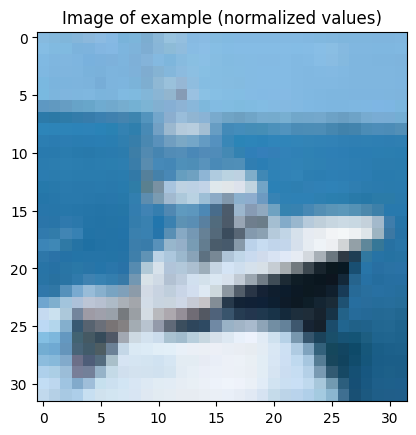

In [6]:
# normalize values to reduce pixel dependency across images
def normalize_image(img):
  return (img - np.min(img)) / (np.max(img) - np.min(img))

normalized_images = normalize_image(images.copy().astype(float))

print("Shape of normalized image data:", normalized_images.shape)
print("Preview of RGB values at first pixel of example:", normalized_images[example_index][0, 0])
print("Average RGB value of example:", np.mean(normalized_images[example_index]))

plt.title("Image of example (normalized values)")
print(plt.imshow(normalized_images[example_index]))

The final step involves splitting the data into training and testing. Although further data processing may be done in the later sections, splitting the data here will ensure the same data is trained for all methods, reducing random bias and error.

<Axes: >

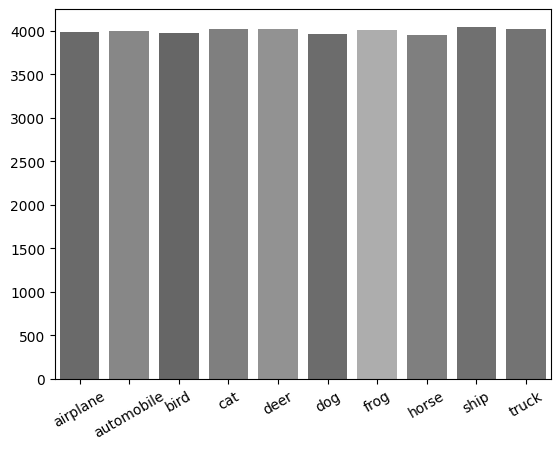

In [7]:
# set proportion of data for testing
test_prop = 0.2

# split the data according to test_prop
images_train, images_test, labels_train, labels_test = train_test_split(normalized_images, labels, test_size = test_prop)

split_plot = np.unique(list(map(label_to_string, labels_train)), return_counts = True)
plt.xticks(rotation=30)
sns.barplot(x = split_plot[0], y = split_plot[1], saturation = 0)


## Model training and testing

This section will involve further preprocessing of the data appropriate for the method and generating the classification models to train and test.

The methods to be used in generating classification models are:
- K-nearest neighbour algorithm (K-NN)
- Convolutional neural network (CNN)
  - LeNet-5
  - VGG16 (adapted)

### K-nearest neighbour algorithm
K-nearest neighbour (K-NN) is an algorithm that involves classification (or prediction) based on an input's *K nearest neighbours* from its training set. It's simple and intuitive, but as data increases, the algorithm becomes increasingly computationally intensive.

<div align="center">
<img src="https://raw.githubusercontent.com/j-ackyao/stat-Wine-Classification/main/images/output_38_0.png" width=60%>

<sup>Visualization of K-NN classification model taken from a previous project</sup>
</div>

#### Preprocessing
For K-NN to process images, the input data should be one dimensional, so the image data needs to be flattened from the 32x32x3 shape. Additionally, since K-NN does not require a formatted output, it is appropriate to map the labels to its string description for easier interpretation. A helper function to plot the training accuracies is also created.

In [20]:
# flatten image data
def flatten_images(images):
  flattened = []
  for i in images:
    flattened.append(i.flatten())
  return np.array(flattened)

images_train_flat = flatten_images(images_train)
images_test_flat = flatten_images(images_test)

print("Shape of flattened training image data:", images_train_flat.shape)
print("Shape of flattened image data:", images_train_flat.shape)

# convert numeric label to string
def string_labels(labels):
  stringed = []
  for l in labels:
    stringed.append(label_to_string(l))
  return np.array(stringed)

labels_train_string = string_labels(labels_train)
labels_test_string = string_labels(labels_test)

print("Shape of labels:", labels_train_string.shape)

# helper to plot accuracies
def plot_knn(ks, accs, times):
    # best epoch determined by validation accuracy
    best_k = ks[np.argmax(accs)]
    f, ax = plt.subplots(1,1)
    ax2 = plt.twinx()
    sns.lineplot(x = ks, y = accs, label = 'Accuracy', ax = ax)
    sns.lineplot(x = ks, y = times, color = 'orange', label = 'Training time', ax = ax2)
    # will change if more data is added
    ax.axhline(1 / len(classes), linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_k, linestyle = '--', color = 'green', label = 'Best Validation accuracy')
    ax.legend(loc = 'right')
    ax2.legend(loc = 'upper right')
    ax.set_ylim([0, 1])
    ax2.set_ylim([50, 100])
    ax.set_xlabel("K")
    ax.set_ylabel("Accuracy")
    ax.set_title("K-NN training accuracies vs. K values")
    plt.show()


Shape of flattened training image data: (40000, 3072)
Shape of flattened image data: (40000, 3072)
Shape of labels: (40000,)


#### Training and testing
Given the previously stated disadvantage of large data, it is difficult to efficiently determine the ideal K value due to the computation times to train with one value of K. Therefore, a small array of K values would be used for "trial and error". The values are arbitrarily chosen, except for 200 which follows a rule of thumb for "square root of the number of data in training".

In [21]:
# list of k values to test
k_values = [1, 3, 5, 10, 30, 50, 100, 200, 500]
accuracies = []
train_test_times = []
knn_model_5 = None

for k in k_values:
  start_time = time.time()
  knn_model = KNeighborsClassifier(k)
  knn_model.fit(images_train_flat, labels_train_string)
  if k == 5:
    knn_model_5 = knn_model

  predictions = knn_model.predict(images_test_flat)
  end_time = time.time()
  accuracy = accuracy_score(predictions, labels_test_string)
  accuracies.append(accuracy)
  train_test_times.append(end_time - start_time)
  print("K-NN model accuracy for K =", k, ":", accuracy)
  print("K-NN training and testing time for K =", k, ":", end_time - start_time)

print("Average training and testing time:", sum(train_test_times) / len(train_test_times))

K-NN model accuracy for K = 1 : 0.3407
K-NN training and testing time for K = 1 : 65.93292427062988
K-NN model accuracy for K = 3 : 0.3276
K-NN training and testing time for K = 3 : 67.49877977371216
K-NN model accuracy for K = 5 : 0.3322
K-NN training and testing time for K = 5 : 70.64304327964783
K-NN model accuracy for K = 10 : 0.3308
K-NN training and testing time for K = 10 : 66.4949300289154
K-NN model accuracy for K = 30 : 0.3192
K-NN training and testing time for K = 30 : 65.93350100517273
K-NN model accuracy for K = 50 : 0.3104
K-NN training and testing time for K = 50 : 67.34413146972656
K-NN model accuracy for K = 100 : 0.2975
K-NN training and testing time for K = 100 : 66.89977693557739
K-NN model accuracy for K = 200 : 0.2824
K-NN training and testing time for K = 200 : 67.59589648246765
K-NN model accuracy for K = 500 : 0.2644
K-NN training and testing time for K = 500 : 68.28067779541016
Average training and testing time: 67.40262900458441


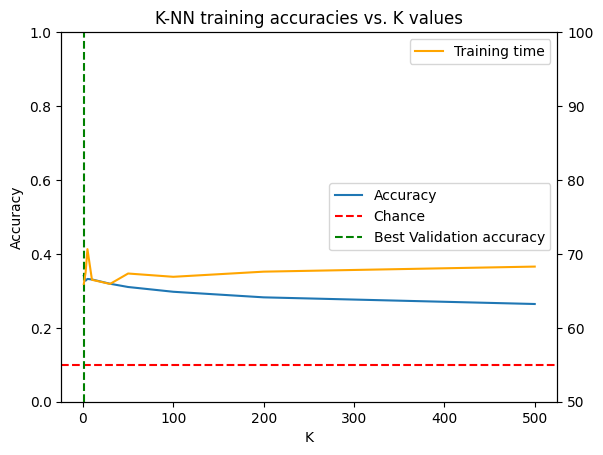

In [22]:
plot_knn(k_values, accuracies, train_test_times)

Deceivingly, it seems like a higher K value performs worse in terms of accuracy. However, a more probable explanation is that due to how K-NN works, it's likely classifying images with the wrong classes, but appearing similar, as it would find images with the closest pixel values rather than the actual object. Despite the fairly low accuracies of ~0.3, it is better than random chance, which would be about 0.1 given that all the classes have roughly equal number of observations. For the simplicity of the model, the accuracy is arguably decent. Additionally, when compared to CNN models later, the time to train this model is relatively quick given the amount of training data.

### Convolutional neural networks

As previously stated, convolutional neural networks (CNN) is an architecture of artifical neural network that learns and identify features through kernels (also called filters) and consist of three main layers (excluding input and output): convolution, pooling, and regular dense layers.

From this simple foundation, many diverse designs would emerge; LeNet-5, dubbed as the pioneering architecture for CNNs, was published in 1998 by Yann LeCun et al. and gained a reputation for outperforming other models at the time in classifying handwritten characters.

<div align="center">
<img src='https://miro.medium.com/v2/resize:fit:4800/format:webp/1*PKC559-N21aNlXvqmR_ELQ.png' width=80%>

<sup>Visualization of LeNet-5 architecture (Yann LeCun et al.)</sup>
</div>


Another notable but more modern architecture is the VGG16, which won first and second place in object detection and classification in the 2014 ImageNet challenge. Developed by Simonyan and Zisserman from the University of Oxford, VGG16 is still considered one of the best for its simplicity (relatively) and ability to identify features in detailed images.


<div align="center">
<img src='https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/vgg.png' width=75%>

<sup>Visualization of VGG16 architecture (Varshney)</sup>
</div>

Both will be implemented in this project and compared, however, VGG16 will instead be used as inspiration to an adapted model accommodate to the 32x32 input. In addition to the architectures, models can be trained with optimizers to *optimize* the accuracies. For this project's purpose, RMSProp will be used as it is considered to be one of the best defaults for achieving the best accuracy in image classification (Verma et al.).

#### Preprocessing
As CNNs are able to produce class probabilities (the probability of being a certain class), the output should be reformatted so that the number of classes is being matched by the number of outputs corresponding to the class as probabilities.

Shape of probability formatted output: (40000, 10)
Preview of probability output of example: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
AxesImage(size=(32, 32))


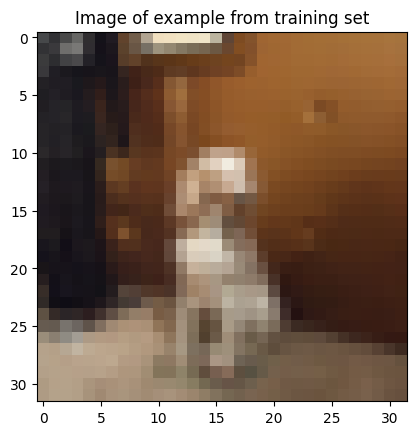

In [28]:
# generate class probabilities for data
def label_prob(labels):
  probs = []
  for l in labels:
    prob = np.zeros(len(classes), dtype = float)
    prob[l] = 1.0
    probs.append(prob)
  return np.array(probs)

labels_train_prob = label_prob(labels_train)
labels_test_prob = label_prob(labels_test)

print("Shape of probability formatted output:", labels_train_prob.shape)
print("Preview of probability output of example:", labels_train_prob[example_index])

plt.title("Image of example from training set")
print(plt.imshow(images_train[example_index]))

Additionally, a few helper functions are created to help further format and interpret the output as well as plot the accuracies during the training process.

In [29]:
# functions to interpret output
def prob_string(output):
  text_output = []
  for i in range(len(output)):
    text_output.append(label_to_string(i) + ": " + output[i].astype(str))
  return ", ".join(text_output)

def prob_guess(output):
  return "Highest probability of " + str(np.max(output)) + " to be " + classes[np.argmax(output)]

print("Class probability of example:", prob_string(labels_train_prob[example_index]))
print("Identifying the example:", prob_guess(labels_train_prob[example_index]))

def plot_cnn(history, title):
    if hasattr(history, 'history_'):
      history = history.history_
    else:
      history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)
    # best epoch determined by validation accuracy
    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']
    f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    # will change if more data is added
    ax.axhline(1 / len(classes), linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best valildation accuracy')
    ax.legend(loc = 'right')
    ax.set_ylim([0, 1])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    plt.show()


Class probability of example: airplane: 0.0, automobile: 0.0, bird: 0.0, cat: 0.0, deer: 0.0, dog: 1.0, frog: 0.0, horse: 0.0, ship: 0.0, truck: 0.0
Identifying the example: Highest probability of 1.0 to be dog


#### Training and testing
Like many things relating to AI, neural network models can easily become complex and computationally intensive, especially if large amounts of data is required for a model to be reliably trained. Although the models are created from existing designs, many hyperparameters can still be configured, e.g. epoch, learning rate, weight decay, etc. However, through much trial and error, a relatively fit and accurate configuration was found for both LeNet-5 and VGG16.

**LeNet-5**

In [17]:
# LeNet-5
lenet = Sequential([
    # C1 or input
    Conv2D(input_shape = (32, 32, 3), filters = 6, kernel_size = 5, activation = 'relu'),
    # S2
    MaxPool2D(pool_size = 2),
    # C3
    Conv2D(input_shape = (32, 32, 3), filters = 16, kernel_size = 5, activation = 'relu'),
    # S4
    MaxPool2D(pool_size = 2),
    # C5
    Conv2D(input_shape = (32, 32, 3), filters = 120, kernel_size = 5, activation = 'relu'),
    # F6
    Flatten(),
    Dense(units = 84, activation = 'relu'),
    # output
    Dense(units = 10, activation = 'softmax')
])

# use RMSprop optimizer
lenet_opt = keras.optimizers.RMSprop(learning_rate=0.0001)

lenet.compile(loss='categorical_crossentropy', optimizer = lenet_opt, metrics=['accuracy'])

# train cnn
start_time = time.time()
lenet_history = lenet.fit(images_train, labels_train_prob, validation_data = (images_test, labels_test_prob), epochs = 50)
end_time = time.time()

print("Training time for LeNet-5:", end_time - start_time)

Epoch 1/50
1250/1250 [==============================] - 18s 11ms/step - loss: 2.0300 - accuracy: 0.2641 - val_loss: 1.8405 - val_accuracy: 0.3450
Epoch 2/50
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7526 - accuracy: 0.3726 - val_loss: 1.6599 - val_accuracy: 0.4058
Epoch 3/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6218 - accuracy: 0.4179 - val_loss: 1.5726 - val_accuracy: 0.4350
Epoch 4/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5492 - accuracy: 0.4446 - val_loss: 1.5217 - val_accuracy: 0.4526
Epoch 5/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5033 - accuracy: 0.4593 - val_loss: 1.4926 - val_accuracy: 0.4659
Epoch 6/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.4680 - accuracy: 0.4717 - val_loss: 1.4596 - val_accuracy: 0.4791
Epoch 7/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4369 - accuracy: 0.4845 - val_loss: 1.4270 - val_accura

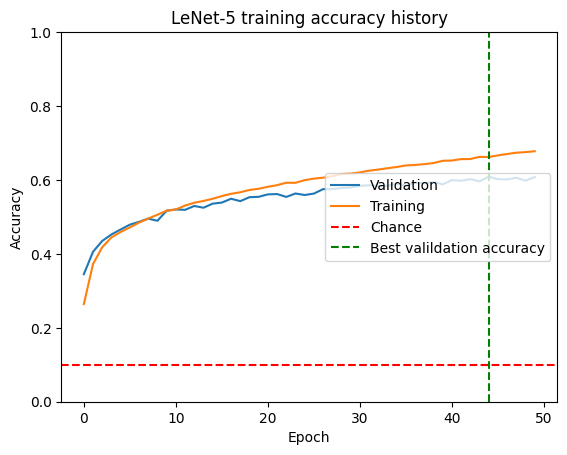

In [18]:
plot_cnn(lenet_history, "LeNet-5 training accuracy history")

Even with such a simple CNN from 1998, the accuracy is double that of K-NN's. However, in real world applications, the accuracy isn't particularly reliable, with it only correctly classifying about 6 out of 10 images. Additionally, it can be seen that the validation accuracy is starting to deviate from the training accuracy without being at a "high accuracy" (accuracy remains around 60%), indicating that this architecture may not be suitable for problem it was trained to solve. As previously stated, the LeNet-5 was developed for black and white images, specifically black handwriting on white background. The addition of color and background noise could be a reason why this architecture was unable to perform at a higher accuracy, given it's limited structure.

**VGG16**

In [10]:
# vgg16
vgg = Sequential([
    # first two convolution layers
    Conv2D(filters = 64, kernel_size = (3, 3), padding='same', activation='relu'),
    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),

    # next three layers
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),

    # next four layers
    MaxPool2D(pool_size = (2, 2), strides = (2, 2)),
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),

    Flatten(),
    Dense(2000, activation='relu'),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# use RMSprop optimizer
vgg_opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0003, decay=0.0001)
vgg.compile(loss='categorical_crossentropy', optimizer = vgg_opt, metrics=['accuracy'])

# train cnn
start_time = time.time()
vgg16_history = vgg.fit(images_train, labels_train_prob, validation_data = (images_test, labels_test_prob), epochs = 20)
end_time = time.time()

print("Training time for VGG16:", end_time - start_time)

Epoch 1/20
1250/1250 [==============================] - 44s 28ms/step - loss: 1.6508 - accuracy: 0.3952 - val_loss: 1.2889 - val_accuracy: 0.5438
Epoch 2/20
1250/1250 [==============================] - 32s 26ms/step - loss: 1.0919 - accuracy: 0.6172 - val_loss: 0.9407 - val_accuracy: 0.6719
Epoch 3/20
1250/1250 [==============================] - 34s 27ms/step - loss: 0.8161 - accuracy: 0.7198 - val_loss: 0.8871 - val_accuracy: 0.7059
Epoch 4/20
1250/1250 [==============================] - 33s 26ms/step - loss: 0.6565 - accuracy: 0.7796 - val_loss: 0.8028 - val_accuracy: 0.7467
Epoch 5/20
1250/1250 [==============================] - 34s 27ms/step - loss: 0.5400 - accuracy: 0.8193 - val_loss: 0.8006 - val_accuracy: 0.7530
Epoch 6/20
1250/1250 [==============================] - 34s 27ms/step - loss: 0.4531 - accuracy: 0.8504 - val_loss: 0.8989 - val_accuracy: 0.7767
Epoch 7/20
1250/1250 [==============================] - 34s 27ms/step - loss: 0.3903 - accuracy: 0.8720 - val_loss: 0.7743 -

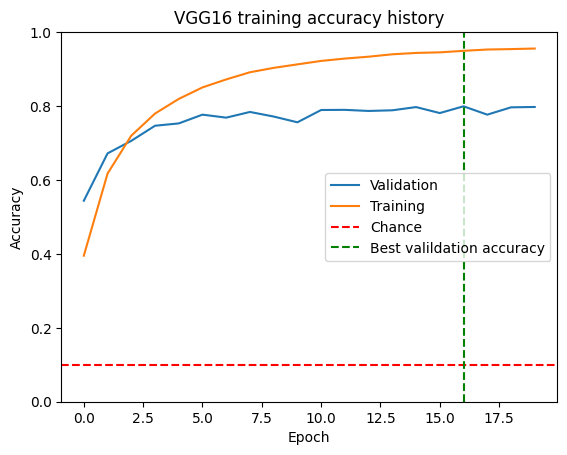

In [11]:
plot_cnn(vgg16_history, "VGG16 training accuracy history")

Although the increase in accuracy isn't as significant as it was from K-NN to LeNet-5, VGG16 (adapted) demonstrated a decent increase in accuracy, with an averaging validation accuracy close to 80%. However, seen in the graph, the training accuracy deviates greatly from the plateauing validation accuracy, indicating severe overfitting in the training subset, despite a large dropout layer. As the original architecture was designed for much larger resolution images, it is likely that even the adapted version was too complex for the 32x32 colored images. Due to this, the CNN may have "identified details" in the training subset that would otherwise be irrelevant in the testing subset. In comparison to LeNet-5, which can't seem to increase training accuracies, VGG16 (adapted) is able to learn very quickly and reach a very high training accuracy, although overfitting. Overall, the validation accuracy is fairly reasonable and practical in real world applications (though there is unlikely any real world applications for identifying 32x32 images presently or the future).

### Review of the classification models

Below is an image of the famous Shiba Inu "Doge", which has been reduced to 32x32 pixels, and the three models will classify it and the results will be compared (this image may or may not already exist in the dataset):

(32, 32, 3)
AxesImage(size=(32, 32))


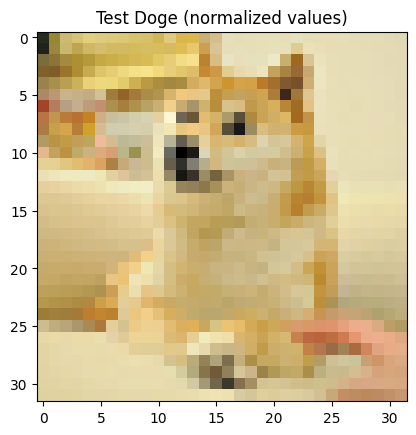

In [12]:
from PIL import Image
import requests

# get the image from repo and load as array
doge = np.array(Image.open(requests.get("https://raw.githubusercontent.com/j-ackyao/object-classification/main/doge.png", stream = True).raw))

# ensure shape is 32x32x3
print(doge.shape)

normalized_doge = normalize_image(doge)

knn_example_input = [normalize_image(normalized_doge).flatten()]
cnn_example_input = np.array([normalize_image(normalized_doge)])

plt.title("Test Doge (normalized values)")
print(plt.imshow(normalized_doge))

In [23]:
print("K-NN prediction of example image:", knn_model_5.predict(knn_example_input)[0])

K-NN prediction of example image: bird


In [30]:
lenet_doge_prediction = lenet.predict(cnn_example_input)[0]
print("LeNet-5 predictions of example image:", prob_string(lenet_doge_prediction))
print("LeNet-5 best prediction of example image:", prob_guess(lenet_doge_prediction))

1/1 [==============================] - 0s 37ms/step
LeNet-5 predictions of example image: airplane: 0.000617038, automobile: 8.485665e-06, bird: 0.46183416, cat: 0.07206732, deer: 0.3372382, dog: 0.101680726, frog: 0.004266793, horse: 0.02227139, ship: 3.4044306e-06, truck: 1.2433463e-05
LeNet-5 best prediction of example image: Highest probability of 0.46183416 to be bird


In [31]:
vgg_doge_prediction = vgg.predict(cnn_example_input)[0]
print("VGG16 (adapted) predictions of example image:", prob_string(vgg_doge_prediction))
print("VGG16 (adapted) best prediction of example image:", prob_guess(vgg_doge_prediction))

1/1 [==============================] - 0s 21ms/step
VGG16 (adapted) predictions of example image: airplane: 6.547125e-27, automobile: 8.033869e-33, bird: 6.515332e-20, cat: 8.0386565e-13, deer: 5.573388e-21, dog: 1.0, frog: 4.7778667e-25, horse: 8.3966285e-23, ship: 2.1591873e-33, truck: 6.8283914e-30
VGG16 (adapted) best prediction of example image: Highest probability of 1.0 to be dog


As expected, the K-NN was unable to predict the image correctly, with an adamant answer of 'bird'.

Looking at all the outcomes of the LeNet-5, though, it's interesting to see that 'dog' is third highest with a probability of 10% and instead 'bird' and 'deer' are predicted with higher probability. This brings question to the idea of '*class probabilities*' and how it should be interpreted: "what does '46% bird' mean?"

Furthermore, it can be seen that the (adapted) VGG16 model has correctly predicted Doge to be a dog, but with a seemingly excessively high probability of 100%. Notably though, all other class probabilities are extremely small.

As a sole number, the highest class probability is mostly uninterpretable ('46% bird', '100% dog'). With context, the probabilities instead provide meaningful insights to the neural network's prediction: LeNet-5 model's low probability of all the classes may be indicating that it is unsure how to classify the image; VGG16 (adapted) model's 100% prediction on 'dog' and extremely low probabilities of all other classes may be indicating absolute certainty. Although there is no given format to interpeting class probabilities, having one is more insightful than having none.

## Discussion

Despite being computationally intensive in general, machine learning can often be the answer to problems that would otherwise be near impossible in the conventional sense of programming. With more complex problems, though, comes with more complex systems in search of an effective and efficient solution. Neural networks, e.g. CNNs, are considered complex machine learning methods that are mostly described at a higher level; a small research field even exists to find ways in effectively describing the "black box" of an AI model to untechnical parties.

However, the complicated internal workings of neural networks allows accurate computational solutions to subjects such as computer vision. As seen through the three models trained in this project, neural networks provide a truly greater advantage given the sufficient resources, with of course their own respective drawbacks, such as overfitting. Additionally, neural networks are able to provide "probabilities" to the outcomes, which may lead to other human interpretations or algorithmic processes; unfortunately, as seen with the Doge example, unfit/inappropriate models produce equally unreliable probabilities.

### Ethics and the future

The ethics of AI and neural networks is one of the biggest concerns now in the world of technology, as it's problem solving scope covers almost anything and it's limitations unknown. Computer vision is no exception, as it's applications can involve high risk decision making, e.g. malignant vs. benign tumour classifications resulting in false positives/negatives, yet it opens a world of new technology many appreciate today, e.g. self-driving cars.

Computers are efficient and errorless in their black and white answers, but once the gray area of uncertainty is introduced, so is the probability of errors. It's important to remember that AI can be helpful, but an increasing reliance on AI can be dangerous. Unlike humans, risk assessment is not inherent in the AI's process (yet). AI should be treated as a tool, as like many others: useful but operate under care.

Seeing the progression from algorithms to simple neural networks to convolutional neural networks, a new system of AI built on today's state-of-the-art architectures could be in the near future, like how many CNNs were built on the findings of LeNet-5.

As for this project's future, an original architecture could be developed to achieve the same computer vision with higher validation accuracy. It could also be the foundation of larger scale AI projects involving higher resolution and or videos, or a research in finding a formula/systematic approach to designing CNNs given the nature of the problem. Nevertheless, this personal project has provided much insight to neural networks and machine learning.

## References
- Patel, Rachana, and Sanskruti Patel. “A Comprehensive Study of Applying Convolutional Neural Network for Computer Vision.” ResearchGate, Jan. 2020, www.researchgate.net/publication/344121826_A_Comprehensive_Study_of_Applying_Convolutional_Neural_Network_for_Computer_Vision.
- Krizhevsky, Alex, et al. CIFAR-10 and CIFAR-100 Datasets. www.cs.toronto.edu/~kriz/cifar.html.
- Varshney, Paras. “VGGNet-16 Architecture: A Complete Guide.” Kaggle, 28 July 2020, www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide.
- Verma, Pratima, et al. “Comparison of Different Optimizers Implemented on the Deep Learning Architectures for COVID-19 Classification.” Materials Today: Proceedings, vol. 46, Elsevier BV, Jan. 2021, pp. 11098–102. https://doi.org/10.1016/j.matpr.2021.02.244.
- Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, https://doi.org/10.1109/5.726791.
- Simonyan, Karen, and Andrew Zisserman. “Very Deep Convolutional Networks for Large-Scale Image Recognition.” Computer Vision and Pattern Recognition, Sept. 2014, https://export.arxiv.org/pdf/1409.1556.